# Handwritting Text Recognition CNN Attention

This pipeline was implemented from [Naveen Reddy Marthala](https://github.com/naveenmarthala/Handwritten-word-recognition-OCR----IAM-dataset---CNN-and-BiRNN/blob/master/notebooks/iam%20on%20july%2025-CNN-BiLSTM.ipynb) Project. <br> But only recognize Alphanumeric character.

The trained model is only capable of recognizing short words composed of alphanumeric characters. It will not be able to predict or accurately handle punctuation, as those characters were deliberately excluded from the models vocabulary and the training data due to resource limitations.

## Import Libraries

In [40]:
import cv2
import seaborn as sns
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import string
%matplotlib inline
import pandas as pd
import gc
from tqdm import tqdm

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Preparation

In [3]:
# Config
DATA_DIR = "IAM_Words"
IMG_DIR = os.path.join(DATA_DIR, "words")
# ANNOTATION = os.path.join(DATA_DIR, "words.txt")
TRAIN_LABEL = os.path.join(DATA_DIR, "train_files.txt")
VALID_LABEL = os.path.join(DATA_DIR, "valid_files.txt")
TEST_LABEL = os.path.join(DATA_DIR, "test_files.txt")
MODEL = os.path.join("model", "HwTR_Attention.h5")

Load image path with the given labels from dataset.
We select the datas which are not more than 16 length and not have punctuation.

In [4]:
def load_img_path_n_text(file):
    """
    read a string like(which can be found in each line of words.txt file):
    'a01-000u-00-00 ok 154 408 768 27 51 AT A'
    and extract 'a01-000u-00-00': location of the image with sub-folders, to read it from the directories
                'ok'            : processing status. ok means good, presumably.
                'A'             : ground truth text

    Then, pre-process using function defined above
    """
    
    dataset = []
    skipped = 0
    with open(file) as f:
        for line in f:
            if not line or line.startswith('#'):
                continue

            line_split = line.strip().split(' ')
            
            # not load 'err'
            if line_split[1] == 'err':
                skipped +=1
                continue

            dir_split = line_split[0].split('-')
            img_path = os.path.join(IMG_DIR, dir_split[0], f"{dir_split[0]}-{dir_split[1]}",f"{line_split[0]}.png")

            gt_text = ' '.join(line_split[8:])

            if len(gt_text) > 16:
                skipped+=1
                continue

            if any(ch in string.punctuation for ch in gt_text):
                skipped += 1
                continue
            
            # print(f"load : {img_path}, texts : {gt_text}")
            dataset.append([img_path, gt_text])

    print(f"skipped = {skipped}")
    return dataset

In [5]:
train_files = load_img_path_n_text(TRAIN_LABEL)
valid_files = load_img_path_n_text(VALID_LABEL)
test_files = load_img_path_n_text(TEST_LABEL)


skipped = 12404
skipped = 646
skipped = 584


In [6]:
print(f"Train = {len(train_files)}")
print(f"Valid = {len(valid_files)}")
print(f"Test = {len(test_files)}")

Train = 74888
Valid = 3670
Test = 3732


Then, we resize all images into same height and width. Then, we convert the images into a grayscale.

In [7]:
def add_padding(img, old_w, old_h, new_w, new_h):
    h1, h2 = int((new_h - old_h) / 2), int((new_h - old_h) / 2) + old_h
    w1, w2 = int((new_w - old_w) / 2), int((new_w - old_w) / 2) + old_w
    img_pad = np.ones([new_h, new_w, 3]) * 255
    img_pad[h1:h2, w1:w2, :] = img
    return img_pad


def fix_size(img, target_w, target_h):
    h, w = img.shape[:2]
    if w < target_w and h < target_h:
        img = add_padding(img, w, h, target_w, target_h)
    elif w >= target_w and h < target_h:
        new_w = target_w
        new_h = int(h * new_w / w)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    elif w < target_w and h >= target_h:
        new_h = target_h
        new_w = int(w * new_h / h)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    else:
        """w>=target_w and h>=target_h """
        ratio = max(w / target_w, h / target_h)
        new_w = max(min(target_w, int(w / ratio)), 1)
        new_h = max(min(target_h, int(h / ratio)), 1)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    return img


def preprocess(path, img_w, img_h):
    """ Pre-processing image for predicting """
    img = cv2.imread(path)
    img = fix_size(img, img_w, img_h)

    img = np.clip(img, 0, 255)
    img = np.uint8(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # type: ignore

    img = img.astype(np.float32)
    img /= 255
    return img

In [8]:
SOS_TOKEN = '<SOS>'
EOS_TOKEN = '<EOS>'

letters = (
    [SOS_TOKEN, EOS_TOKEN, ' '] +
    [str(d) for d in range(10)] +
    [chr(c) for c in range(ord('A'), ord('Z')+1)] +
    [chr(c) for c in range(ord('a'), ord('z')+1)]
)

char_to_int = {c: i for i, c in enumerate(letters)}
int_to_char = {i: c for i, c in enumerate(letters)}

num_classes = len(letters)

In [9]:
def text_to_labels_attention(text):
    return [char_to_int[SOS_TOKEN]] + \
           [char_to_int[c] for c in text] + \
           [char_to_int[EOS_TOKEN]]

From some experiment, there is a image that cannot be read. Therefore, we delete it.

In [10]:
for index, (img_loc, gt_text) in enumerate(train_files):
    if 'r06-022-03-05' in img_loc:
        print(index)
        print(train_files[index])
        del train_files[index]
        print(train_files[index])
    else:
        continue

3936
['IAM_Words\\words\\r06\\r06-022\\r06-022-03-05.png', 'more']
['IAM_Words\\words\\g06\\g06-042e\\g06-042e-05-03.png', 'notice']


done


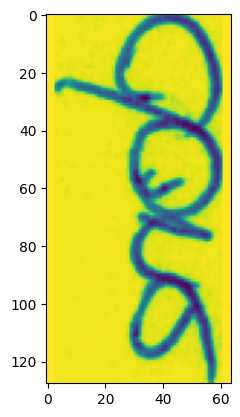

In [11]:
i = 21
print(train_files[i][1])
an_img = preprocess(path=train_files[i][0], img_w=128, img_h=64)
plt.imshow(an_img.T)

## Building Image data

In [12]:
class TextImageGenerator:
    def __init__(self, data, img_w, img_h,  batch_size,  i_len, max_text_len):
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.samples = data
        self.n = len(self.samples)
        self.i_len = i_len
        self.indexes = list(range(self.n))
        self.cur_index = 0

    def build_data(self):
        self.texts = [text for _, text in self.samples]
    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        
        img_path, text = self.samples[self.indexes[self.cur_index]]
        img = preprocess(img_path, self.img_w, self.img_h)
        return img, text

    def next_batch(self):
        while True:
            X_img = np.ones((self.batch_size, self.img_w, self.img_h, 1), dtype=np.float32)
            decoder_input = np.zeros((self.batch_size, self.max_text_len), dtype=np.int32)
            decoder_target = np.zeros((self.batch_size, self.max_text_len), dtype=np.int32)

            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                img = np.expand_dims(img, -1)
                X_img[i] = img

                label = text_to_labels_attention(text)
                label = label[:self.max_text_len]

                decoder_input[i, :len(label)-1] = label[:-1]
                decoder_target[i, :len(label)-1] = label[1:]
            yield ([X_img, decoder_input], decoder_target)


    def peek_images(self, n=5):
        """
        Load and return the first n images and their texts for inspection.
        Does NOT preload the whole dataset.
        """
        peek_imgs = []
        peek_texts = []
        
        for i in range(min(n, self.n)):
            img_path, text = self.samples[i]
            img = preprocess(img_path, self.img_w, self.img_h)
            peek_imgs.append(img)
            peek_texts.append(text)
            
        return np.array(peek_imgs), peek_texts

In [13]:
BATCH_SIZE = 64
INPUT_LENGHT = 16
MAX_TEXT_LENGTH = 16
IMG_W = 128
IMG_H = 64

In [14]:
train_data = TextImageGenerator(train_files, IMG_W, IMG_H, BATCH_SIZE, INPUT_LENGHT, MAX_TEXT_LENGTH)
train_data.build_data()

In [15]:
images, texts = train_data.peek_images(n=3)
print("Peek images shape:", images.shape)  # (3, img_h, img_w)
print("Texts:", texts)

Peek images shape: (3, 64, 128)
Texts: ['policy', 'towns', 'Being']


In [16]:
valid_data = TextImageGenerator(valid_files, IMG_W, IMG_H, BATCH_SIZE, INPUT_LENGHT, MAX_TEXT_LENGTH)
valid_data.build_data()

In [17]:
images, texts = valid_data.peek_images(n=3)
print("Peek images shape:", images.shape)  # (3, img_h, img_w)
print("Texts:", texts)

Peek images shape: (3, 64, 128)
Texts: ['latter', 'possible', 'that']


In [18]:
del images, texts
gc.collect()

0

## MODELING

In [19]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as F

tf.keras.backend.set_image_data_format('channels_last')
tf.keras.backend.image_data_format()
     

'channels_last'

In [20]:
input_data = tf.keras.layers.Input(name='input', shape=(IMG_W,IMG_H,1), dtype='float32')  # (None, 128, 64, 1)

# Convolution layer (VGG)
x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='max1')(x)  # (None,64, 32, 64)

x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='max2')(x)

x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(1, 2), name='max3')(x)  # (None, 32, 8, 256)

x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', name='conv6')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(1, 2), name='max4')(x)

x = tf.keras.layers.MaxPooling2D(pool_size=(2, 1), name='max5')(x)

x = tf.keras.layers.Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

# CNN to RNN
x = tf.keras.layers.Reshape(target_shape=((16, 2048)), name='reshape')(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(x)

# RNN layer
# layer ten
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, return_sequences=True))(x)
# layer nine
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, return_sequences=True))(x)
x = tf.keras.layers.BatchNormalization()(x)

encoder_outputs = x

decoder_inputs = tf.keras.layers.Input(
    shape=(MAX_TEXT_LENGTH,),
    name="decoder_inputs"
)

decoder_embedding = tf.keras.layers.Embedding(
    input_dim=num_classes,
    output_dim=512,
    mask_zero=True
)(decoder_inputs)

attention = tf.keras.layers.AdditiveAttention(name="attention")
context = attention([decoder_embedding, encoder_outputs])

decoder_lstm = tf.keras.layers.LSTM(
    256, return_sequences=True
)
decoder_outputs = decoder_lstm(context)

decoder_dense = tf.keras.layers.Dense(
    num_classes, activation="softmax"
)
decoder_outputs = decoder_dense(decoder_outputs)

model = tf.keras.Model(
    inputs=[input_data, decoder_inputs],
    outputs=decoder_outputs
)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1 (Conv2D)                 (None, 128, 64, 64)  640         ['input[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 64, 64)  256        ['conv1[0][0]']                  
 alization)                                                                                       
                                                                                              

In [21]:
import time
from tensorflow.keras.callbacks import Callback

class EpochTimeHistory(Callback):
    """
    a custom callback to print the time(in minutes, to console) each epoch took during.
    """
    def on_train_begin(self, logs={}):
        self.train_epoch_times = []
        self.valid_epoch_times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        cur_epoch_time = round((time.time() - self.epoch_time_start)/60, 4)
        self.train_epoch_times.append(cur_epoch_time)
        print(" ;epoch {0} took {1} minutes.".format(epoch+1, cur_epoch_time))


    def on_test_begin(self, logs={}):
        self.test_time_start = time.time()

    def on_test_end(self, logs={}):
        cur_test_time = round((time.time() - self.test_time_start)/60, 4)
        self.valid_epoch_times.append(cur_test_time)
        print(" ;validation took {} minutes.".format(cur_test_time))

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_save_cb = ModelCheckpoint(filepath=os.path.join("save", "{epoch:03}-val_loss{val_loss:.3f}.h5"),
                                verbose=1, save_best_only=False, monitor='val_loss', save_weights_only=False)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min', restore_best_weights=True)
# reduce_learning_rate_cb = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, cooldown=2, min_lr=0.00001, verbose=1)
epoch_times = EpochTimeHistory()

In [23]:
BATCH_SIZE, train_data.n, valid_data.n

(64, 74887, 3670)

## Training

In [21]:
EPOCHS = 30

In [25]:
history_model_3 = model.fit(train_data.next_batch(),
                            validation_data=valid_data.next_batch(),
                            steps_per_epoch=train_data.n/BATCH_SIZE,
                            validation_steps=valid_data.n // BATCH_SIZE,
                            epochs=EPOCHS,
                            callbacks=[earlystop, model_save_cb, epoch_times])

Epoch 1/30
1171/1170 [==============================] - ETA: 0s - loss: 0.4327 - accuracy: 0.5424 ;validation took 0.6454 minutes.

Epoch 1: saving model to save\001-val_loss0.284.h5
 ;epoch 1 took 12.8927 minutes.
1170/1170 [==============================] - 774s 636ms/step - loss: 0.4327 - accuracy: 0.5424 - val_loss: 0.2840 - val_accuracy: 0.6938
Epoch 2/30
1171/1170 [==============================] - ETA: 0s - loss: 0.2134 - accuracy: 0.7762 ;validation took 0.4319 minutes.

Epoch 2: saving model to save\002-val_loss0.165.h5
 ;epoch 2 took 14.8797 minutes.
1170/1170 [==============================] - 893s 763ms/step - loss: 0.2134 - accuracy: 0.7762 - val_loss: 0.1651 - val_accuracy: 0.8256
Epoch 3/30
1171/1170 [==============================] - ETA: 0s - loss: 0.1311 - accuracy: 0.8645 ;validation took 0.2467 minutes.

Epoch 3: saving model to save\003-val_loss0.186.h5
 ;epoch 3 took 16.6858 minutes.
1170/1170 [==============================] - 1001s 856ms/step - loss: 0.1311 - ac

In [26]:
model.save(MODEL)

In [22]:
del train_data, valid_data, train_files
gc.collect()

26792

## Plotting

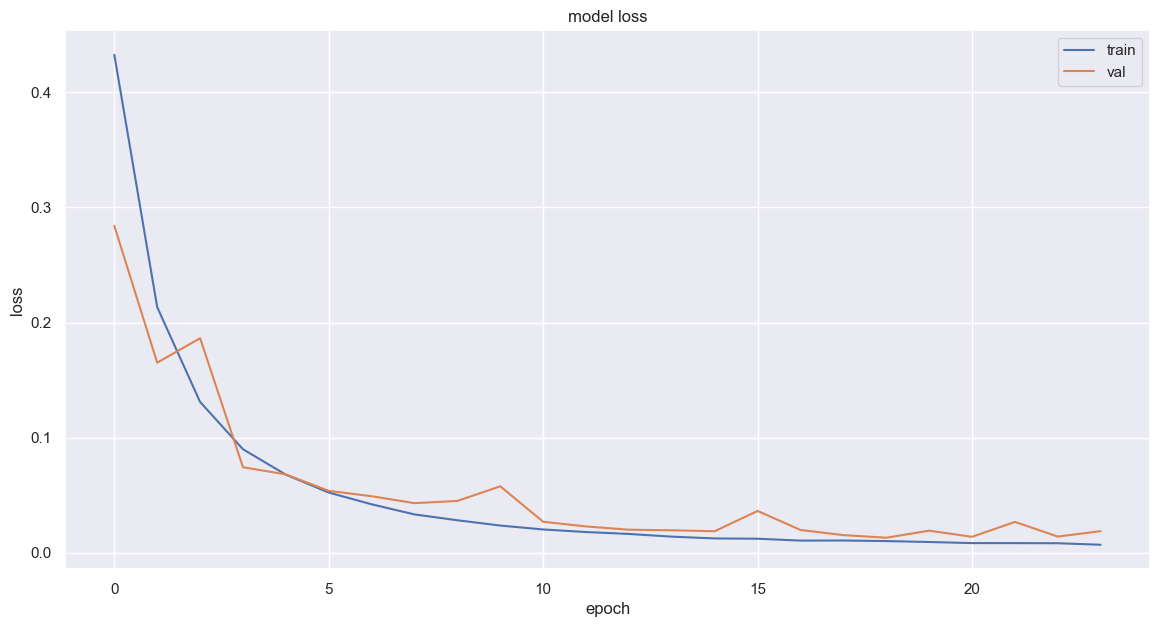

In [28]:
sns.set(rc={'figure.figsize':(14,7)})
plt.plot(history_model_3.history['loss'])
plt.plot(history_model_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

## Evaluation

In [30]:
loss_df = pd.DataFrame(data=history_model_3.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.432688,0.542409,0.284045,0.693800
1,0.213379,0.776174,0.165102,0.825620
2,0.131055,0.864467,0.186409,0.810576
3,0.089890,0.908069,0.074283,0.920594
4,0.067822,0.930894,0.068072,0.928023


In [31]:
loss_df.sort_values(by=['loss', 'val_loss']).head()

,loss,accuracy,val_loss,val_accuracy
23,0.006923,0.992569,0.018748,0.981574
22,0.008239,0.991174,0.014013,0.988515
21,0.008347,0.991015,0.026778,0.975549
20,0.008366,0.991065,0.013812,0.986417
19,0.009313,0.989823,0.019147,0.980403


## Prediction and CER WER metrics

In [32]:
test_images_processed = []
original_test_texts = []
for _, (test_image_path, original_test_text) in enumerate(test_files):
     temp_processed_image = preprocess(path=test_image_path, img_w=128, img_h=64)
     test_images_processed.append(temp_processed_image.T)
     original_test_texts.append(original_test_text)

valid_images_processed = []
original_valid_texts = []
for _, (valid_image_path, original_valid_text) in enumerate(valid_files):
     temp_processed_image = preprocess(path=valid_image_path, img_w=128, img_h=64)
     valid_images_processed.append(temp_processed_image.T)
     original_valid_texts.append(original_valid_text)

In [25]:
test_images_processed = np.array(test_images_processed)
test_images_processed = test_images_processed.reshape(len(test_files), 128, 64, 1)
print(test_images_processed.shape)

valid_images_processed = np.array(valid_images_processed)
valid_images_processed = valid_images_processed.reshape(len(valid_files), 128, 64, 1)
print(valid_images_processed.shape)

(3732, 128, 64, 1)
(3670, 128, 64, 1)


In [26]:
model_pred = None
model_pred = tf.keras.Model(
    inputs=[input_data, decoder_inputs],
    outputs=decoder_outputs
)

In [27]:
model_pred.load_weights(MODEL)

In [35]:
@tf.function
def decode_step(model, image, decoder_input):
    return model([image, decoder_input], training=False)

def decode_attention(model, image):
    decoded = [char_to_int[SOS_TOKEN]]

    for _ in range(MAX_TEXT_LENGTH - 1):
        decoder_input = np.zeros((1, MAX_TEXT_LENGTH), dtype=np.int32)
        decoder_input[0, :len(decoded)] = decoded

        preds = decode_step(
            model,
            image[None, ...],
            decoder_input
        )

        next_char = tf.argmax(preds[0, len(decoded)-1])
        next_char = int(next_char.numpy())

        if int_to_char[next_char] == EOS_TOKEN:
            break

        decoded.append(next_char)

    return ''.join(int_to_char[i] for i in decoded[1:])



In [36]:
predicted_test_texts = []

for i in range(3):
    img = test_images_processed[i]
    pred_text = decode_attention(model_pred, img)
    predicted_test_texts.append(pred_text)

    if i < 5:
        print("Real :", original_test_texts[i])
        print("Predicted :", pred_text)
        print()


Real : certain
Predicted : Rertain

Real : biographies
Predicted : Riagraphies

Real : all
Predicted : Rl



Calculate the WER and CER

In [38]:
#define function
def levenshtein_distance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        new_distances = [i2 + 1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                cost = 0
            else:
                cost = 1
            new_distances.append(min(new_distances[-1] + 1,
                                     distances[i1] + cost,
                                     distances[i1 + 1] + 1))
        distances = new_distances
    return distances[-1]

def calculate_cer_manual(original_text, predicted_text):
    distance = levenshtein_distance(original_text, predicted_text)
    total_chars = len(original_text)
    if total_chars == 0:
        return 0.0
    return distance / total_chars

def calculate_wer_manual(original_text, predicted_text):
    original_words = original_text.split()
    predicted_words = predicted_text.split()
    distance = levenshtein_distance(original_words, predicted_words)
    total_words = len(original_words)
    if total_words == 0:
        return 0.0
        
    return distance / total_words



CER and WER using test dataset

In [41]:
all_cer_scores = []
all_wer_scores = []

for i in tqdm(range(len(test_images_processed)), desc="Evaluating (TEST)"):
    original_text = original_test_texts[i]
    predicted_text = decode_attention(model_pred, test_images_processed[i])

    cer_score = calculate_cer_manual(original_text, predicted_text)
    wer_score = calculate_wer_manual(original_text, predicted_text)

    all_cer_scores.append(cer_score)
    all_wer_scores.append(wer_score)

    if i < 10:
        print(f"Original : {original_text}")
        print(f"Predicted: {predicted_text}")
        print(f"CER: {cer_score:.4f}, WER: {wer_score:.4f}\n")

print("="*40)
print(f"FINAL AVG CER (TEST): {np.mean(all_cer_scores):.4f}")
print(f"FINAL AVG WER (TEST): {np.mean(all_wer_scores):.4f}")
print("="*40)


Evaluating (TEST):   0%|          | 1/3732 [00:00<17:58,  3.46it/s]

Original : certain
Predicted: Rertain
CER: 0.1429, WER: 1.0000



Evaluating (TEST):   0%|          | 4/3732 [00:00<09:17,  6.68it/s]

Original : biographies
Predicted: Riagraphies
CER: 0.1818, WER: 1.0000

Original : all
Predicted: Rl
CER: 0.6667, WER: 1.0000

Original : It
Predicted: R
CER: 1.0000, WER: 1.0000

Original : I
Predicted: R
CER: 1.0000, WER: 1.0000



Evaluating (TEST):   0%|          | 7/3732 [00:01<08:09,  7.62it/s]

Original : show
Predicted: Rhow
CER: 0.2500, WER: 1.0000

Original : Kings
Predicted: Rings
CER: 0.2000, WER: 1.0000



Evaluating (TEST):   0%|          | 9/3732 [00:01<06:22,  9.72it/s]

Original : A
Predicted: R
CER: 1.0000, WER: 1.0000

Original : the
Predicted: Re
CER: 0.6667, WER: 1.0000

Original : and
Predicted: Rund
CER: 0.6667, WER: 1.0000



Evaluating (TEST): 100%|██████████| 3732/3732 [08:06<00:00,  7.67it/s]

FINAL AVG CER (TEST): 0.4154
FINAL AVG WER (TEST): 0.9973


CER and WER using validation dataset

In [42]:
all_cer_scores = []
all_wer_scores = []

for i in tqdm(range(len(valid_images_processed)), desc="Evaluating (TEST)"):
    original_text = original_valid_texts[i]
    predicted_text = decode_attention(model_pred, valid_images_processed[i])

    cer_score = calculate_cer_manual(original_text, predicted_text)
    wer_score = calculate_wer_manual(original_text, predicted_text)

    all_cer_scores.append(cer_score)
    all_wer_scores.append(wer_score)

print("="*40)
print(f"FINAL AVG CER (VAL): {np.mean(all_cer_scores):.4f}")
print(f"FINAL AVG WER (VAL): {np.mean(all_wer_scores):.4f}")
print("="*40)


Evaluating (TEST): 100%|██████████| 3670/3670 [07:59<00:00,  7.65it/s]

FINAL AVG CER (VAL): 0.4146
FINAL AVG WER (VAL): 0.9943
